In [1]:
# @title 1. Setting up our AI settings enviroment
# Include needed libraries
import os
import torch
import datetime
import cv2
import matplotlib.pyplot as plt

!nvidia-smi

HOME = os.getcwd()
print("HOME:", HOME)

!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))


DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

os.environ["OPENCV_FFMPEG_CAPTURE_OPTIONS"] = "rtsp_transport;udp"

mask_predictor = SamPredictor(sam)

Fri Feb 14 23:30:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [2]:
# @title 2. Connect to our Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# @title 3. Set metada of VIDEO we want to analyze
#Do not forget to upload the video to main folder
#EJEMPLO: MAIN_PATH = "/content/gdrive/MyDrive/PUCP/Tensile Test/dataset/"
MAIN_PATH = '/content/gdrive/MyDrive/Tensile/Datasets/' # @param {type:"string"}
VIDEO_NAME = 'VCL-UP2.mp4' # @param {type:"string"}
VIDEO_PATH = MAIN_PATH + VIDEO_NAME

In [4]:
# @title 4. Select bounding box of our specimen
import cv2
import numpy as np
import supervision as sv

cap = cv2.VideoCapture(VIDEO_PATH)
frame_percentage = 0.95 # @param {type:"slider", min:0, max:1, step:0.05}

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

pos = int(total_frames*frame_percentage)
# Set the frame position to the 100th frame (0-based index)
cap.set(cv2.CAP_PROP_POS_FRAMES, pos)

# Read the frame
ret, frame = cap.read()

# Save frame
img_name = str(pos+1)+'th_frame.png'
cv2.imwrite(img_name, frame)
IMAGE_PATH = "/content/"+img_name

# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded
################################################################################

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

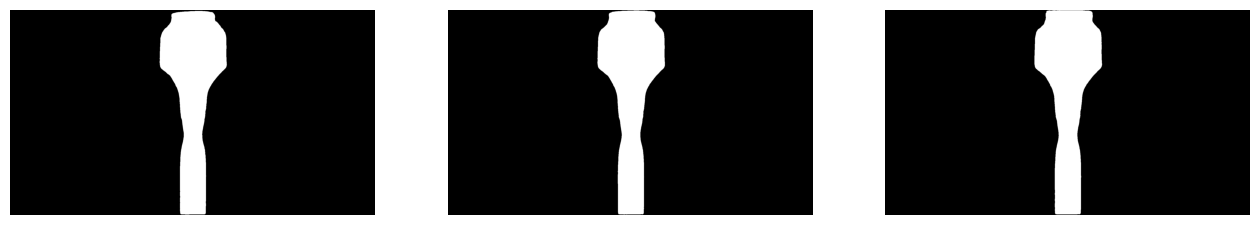

In [6]:
# @title 5. Watch masks of our specimen
bound = widget.bboxes[0]
bound['x']

import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 0, 'y': 0, 'width': 1280, 'height':720 , 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
#image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_bgr)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

# box_annotator = sv.BoxAnnotator(color=sv.Color.green())
# mask_annotator = sv.MaskAnnotator(color=sv.Color.green(), color_lookup=sv.ColorLookup.INDEX)

# detections = sv.Detections(
#     xyxy=sv.mask_to_xyxy(masks=masks),
#     mask=masks
# )
# detections = detections[detections.area == np.max(detections.area)]

# source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
# segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# sv.plot_images_grid(
#     images=[source_image, segmented_image],
#     grid_size=(1, 2),
#     titles=['source image', 'segmented image']
# )

import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 3),
    size=(16, 4)
)
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
#sv.plot_image(
#    image = masks[2],
#    size=(16, 4)
#)
#sv.plot_image(
#    image = cv2.morphologyEx(masks[2].astype(np.uint8), cv2.MORPH_CLOSE, kernel),
#    size=(16, 4)
#)

In [7]:
# @title 6. Choose a mask of our specimen
CHOSEN_MASk = 2 # @param {type:"slider", min:0, max:2, step:1}

In [8]:
# @title 7. Run the model (and get the result data)
import cv2
import numpy as np
import supervision as sv
import csv

################################################################################
def calculate_length_lines(mask, start_row, end_row):
    """
    - Calculate the lengths of lines within a specified range of rows in a binary mask.
    - Parameters:
        mask (numpy.ndarray): Binary mask representing the lines.
        start_row (int): Index of the starting row.
        end_row (int): Index of the ending row.
     -Returns:
        list: Lengths of lines found within the specified row range.
    """
    # Sum the values of each row within the specified range
    row_sums = np.sum(mask[start_row:end_row + 1], axis=1)
    #print(row_sums)
    # Initialize an empty list to store line lengths
    line_lengths = []

    # Iterate over the row sums and add non-zero lengths to the list
    i = 0
    less_length = 999
    for row_sum in row_sums:
        if row_sum != 0:
            line_lengths.append(row_sum)

    #print(line_lengths)

    return line_lengths
################################################################################
def calculate_length_columns(mask, start_col, end_col):
    """
    - Calculate the lengths of lines within a specified range of columns in a binary mask.
    - Parameters:
        mask (numpy.ndarray): Binary mask representing the lines.
        start_col (int): Index of the starting column.
        end_col (int): Index of the ending column.
    - Returns:
        list: Lengths of lines found within the specified column range.
    """
    start_col = bound['x']
    end_col = bound['x'] + bound['width']
    # Sum the values of each column within the specified range
    col_sums = np.sum(mask[:, start_col:end_col + 1], axis=0)
    print(col_sums)

    # Initialize an empty list to store line lengths
    line_lengths = []

    # Iterate over the column sums and add non-zero lengths to the list
    line_lengths = [col_sum for col_sum in col_sums if col_sum != 0]

    return line_lengths
################################################################################
def calculate_curvature_radius(mask, start_col, end_col, start_row, end_row):
    """
    - Calculate the lengths of lines within a specified range of columns in a binary mask.
    - Parameters:
        mask (numpy.ndarray): Binary mask representing the lines.
        start_col (int): Index of the starting column.
        end_col (int): Index of the ending column.
    - Returns:
        list: Lengths of lines found within the specified column range.
    """
    # Conversion factor
    conversion_factor = 60/828

    # Sum the values of each column within the specified range
    col_sums = np.sum(mask[:, start_col:end_col + 1], axis=0)

    # Initialize an empty list to store line lengths
    radius_list = []

    less_length = 999
    new_value = 0
    last_value = 0
    interest_length = 0
    i=0

    length_col = len(col_sums)

    for col_sum in col_sums:
        if col_sum != 0:
          new_value = col_sum
          if (int(new_value) - int(last_value)) > 140 and i>length_col*0.1 and i<length_col*0.9:
            #print(new_value - last_value)
            interest_length = new_value
            #print(interest_length)
          if new_value > last_value:
            highest_length = new_value
          last_value = new_value
        i+=1

    delta_h = (int(highest_length) - int(interest_length))//2
    #print("Values:\n")
    #print(highest_length)
    #print(interest_length)
    #print(delta_h)
    delta_h_mm = ((int(highest_length) - int(interest_length))*conversion_factor)/2

    # Sum the values of each column within the specified range
    row_sums = np.sum(mask[start_row:end_row + 1], axis=1)

    length_row = len(row_sums)
    i = 0
    min_diameter = 999
    exp_diameter = 0
    flag = 0
    row_index = -1

    for row_sum in row_sums:
        if row_sum != 0:
          if row_sum < min_diameter and i>length_row*0.1 and i<length_row*0.9:
            min_diameter = row_sum
            row_index = i
          if i == row_index + delta_h:
            exp_diameter = row_sum
        i += 1
    i=0
    for row_sum in row_sums:
        if row_sum != 0:
          if i == row_index - delta_h:
            exp_diameter = row_sum
        i += 1

    #print(min_diameter)
    #print(exp_diameter)
    min_diameter_mm = conversion_factor*int(min_diameter)
    exp_diameter_mm = conversion_factor*int(exp_diameter)

    radius_list.append(min_diameter_mm)

    curvature_radius = (pow(exp_diameter_mm - min_diameter_mm,2) + 4*pow(delta_h_mm,2))/(4*(exp_diameter_mm-min_diameter_mm))

    radius_list.append(curvature_radius)

    # Iterate over the column sums and add non-zero lengths to the list

    return radius_list
################################################################################
def generate_list_length2(mask, num_lines, bound):
    """
    - Generate a list of line lengths within the specified mask.
    - This function draws a grid on the mask, generates a mask for lines,
    and calculates the lengths of lines within the bounding box specified by 'bound'.
    - Parameters:
        mask (numpy.ndarray): Binary mask representing the lines.
        num_lines (int): Number of lines to draw on the mask.
        bound (dict): Dictionary containing bounding box information
                      with keys 'x', 'y', 'width', and 'height'.
    - Returns:
        list: Lengths of lines within the bounding box specified by 'bound'.
    """
    #print(bound['x'])
    #print(bound['width'])
    #print(bound['y'])
    #print(bound['height'])
    lengths = calculate_length_lines(mask, bound['y'], bound['y'] + bound['height'])

    return lengths
################################################################################
def generate_list_length_col(mask, bound):
    """
    - Generate a list of line lengths within the specified mask.
    - This function draws a grid on the mask, generates a mask for lines,
    and calculates the lengths of lines within the bounding box specified by 'bound'.
    - Parameters:
        mask (numpy.ndarray): Binary mask representing the lines.
        bound (dict): Dictionary containing bounding box information
                      with keys 'x', 'y', 'width', and 'height'.
    - Returns:
        list: Lengths of lines within the bounding box specified by 'bound'.
    """
    lengths_col = calculate_curvature_radius(mask, bound['x'], bound['x'] + bound['width'],bound['y'], bound['y'] + bound['height'])
    #lengths_col = calculate_length_columns(mask, bound['x'], bound['x'] + bound['width'])
    return lengths_col
################################################################################
def show_img(image):
  # Display the image
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

def seconds_to_hhmmssff(seconds, fps):
    total_frames = seconds * fps
    total_seconds = total_frames / fps
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    frames = int(total_frames % fps)
    return "{:02d}:{:02d}:{:02d}:{:02d}".format(hours, minutes, seconds, frames)

def process_video(video_path, sample_rate=30, box=None, bound=None, n_mask=0,OUTPUT_NAME='tensile-test.csv'):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0  # Initialize frame count
    lengths_list = []  # Create an empty list to store mask_predictor
    reserve_list = []
    ll = []
    lcol = []
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            print('No frames grabbed!')
            break

        if frame_count % sample_rate == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Mask generation
            mask_predictor.set_image(frame_rgb)
            masks, scores, logits = mask_predictor.predict(
                box=box,
                multimask_output=True
            )

            # Mask analysis
            refined_mask = cv2.morphologyEx(masks[n_mask].astype(np.uint8), cv2.MORPH_CLOSE, kernel)
            ll = generate_list_length_col(refined_mask, bound)
            if frame_count > 0:
              if ll[0] >= reserve_list[0]:
                ll[0] = reserve_list[0]
              if ll[1] >= reserve_list[1]:
                ll[1] = reserve_list[1]
            reserve_list = ll

            # Calculate timestamp based on frame count and sample rate
            timestamp_seconds = frame_count / sample_rate

            # Convert timestamp to HH:MM:SS:FF format
            formatted_time = seconds_to_hhmmssff(timestamp_seconds, sample_rate)

            # Append timestamp along with ll to lengths_list
            lengths_list.append((formatted_time, ll))

        frame_count += 1

    # Write lengths_list to CSV
    with open(OUTPUT_NAME, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(lengths_list)

    #print(lengths_list)
    return lengths_list

SAMPLE_RATE = 120 # @param {type:"number"}

OUTPUT_NAME = 'tensile_test3.csv'# @param {type:"string"}
lengths_col = process_video(VIDEO_PATH,box=box,bound=bound,n_mask=CHOSEN_MASk,OUTPUT_NAME=OUTPUT_NAME)

No frames grabbed!
